In [158]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
# Generate training data
np.random.seed(42)
num_samples = 1000
x_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
t_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
u_exact = np.sin(np.pi * x_train) * np.exp(-np.pi**2 * t_train)

# Convert to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_exact_tf = tf.convert_to_tensor(u_exact, dtype=tf.float32)

# Combine x and t for training input
input_train = tf.concat([x_train_tf, t_train_tf], axis=1)

# Generate test data for prediction
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
t_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Convert to TensorFlow tensors
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)

input_test = tf.concat([x_test_tf, t_test_tf], axis=1)

u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)
u_exact_test_tf = tf.convert_to_tensor(u_exact_test, dtype=tf.float32)

In [160]:
model=Sequential([
    # tf.keras.Input((1000,2)),
    Dense(units=50,activation='tanh'),
    Dense(units=50,activation='tanh'),
    Dense(units=1,activation='linear')
])

In [170]:
def loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat((x, t), axis=1))
        du_x = tape.gradient(u_pred, x)
        du_xx = tape.gradient(du_x, x)
        du_dt = tape.gradient(u_pred, t)
        del tape

    alpha = 0.00001
    physics_residual = du_dt - alpha * du_xx
    physics_loss = tf.reduce_mean(tf.square(physics_residual))
    data_loss = tf.reduce_mean(tf.square(u_pred - u_exact_tf))
    total_loss = physics_loss + data_loss
    
    return total_loss, physics_loss, data_loss

In [171]:
from tensorflow.keras.optimizers import Adam

In [172]:
optimizer=Adam(learning_rate=1e-3)

In [173]:
num_epochs = 2000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        total_loss, physics_loss_value, data_loss_value = loss(model, x_train_tf, t_train_tf)
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Total Loss: {total_loss.numpy()}, Physics Loss: {physics_loss_value.numpy()}, Data Loss: {data_loss_value.numpy()}")

Epoch 0/2000, Total Loss: 0.01908724382519722, Physics Loss: 0.0008973983349278569, Data Loss: 0.018189845606684685
Epoch 100/2000, Total Loss: 0.019085492938756943, Physics Loss: 0.000883165979757905, Data Loss: 0.01820232719182968
Epoch 200/2000, Total Loss: 0.019083641469478607, Physics Loss: 0.0008974846568889916, Data Loss: 0.018186157569289207
Epoch 300/2000, Total Loss: 0.019081488251686096, Physics Loss: 0.0008998232078738511, Data Loss: 0.018181664869189262
Epoch 400/2000, Total Loss: 0.019079161807894707, Physics Loss: 0.0009022613521665335, Data Loss: 0.01817690022289753
Epoch 500/2000, Total Loss: 0.019076814875006676, Physics Loss: 0.0009046799968928099, Data Loss: 0.018172135576605797
Epoch 600/2000, Total Loss: 0.019074520096182823, Physics Loss: 0.0009068299550563097, Data Loss: 0.018167689442634583
Epoch 700/2000, Total Loss: 0.01907229796051979, Physics Loss: 0.0009085518540814519, Data Loss: 0.01816374622285366
Epoch 800/2000, Total Loss: 0.019070148468017578, Physic

In [174]:
u_pred = model(tf.concat([input_test], axis=1))

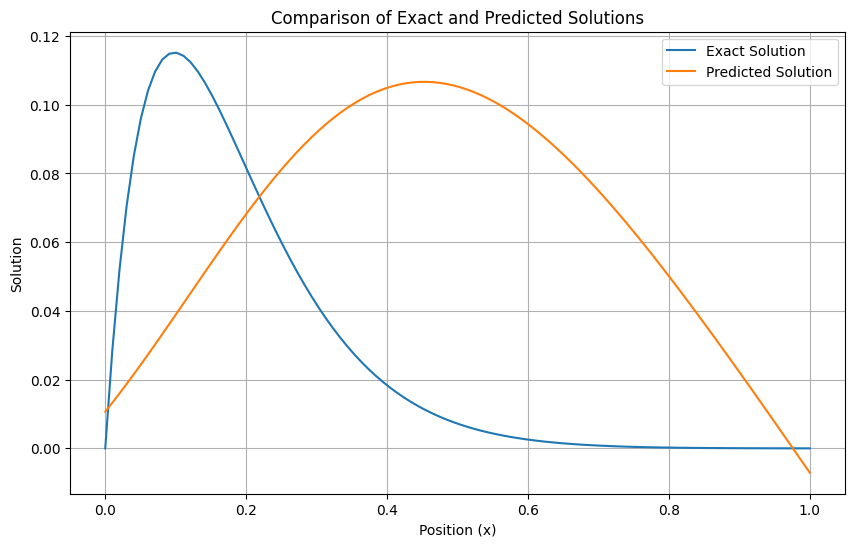

In [178]:
# Plot exact and predicted solutions against position (x)
plt.figure(figsize=(10, 6))  # Adjust figure size
plt.plot(x_test, u_exact_test, label='Exact Solution')
plt.plot(x_test, u_pred, label='Predicted Solution')
plt.xlabel('Position (x)')
plt.ylabel('Solution')
plt.title('Comparison of Exact and Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()